In [2]:
import random
import datetime
import time
import tqdm
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import glob

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer, mean_squared_log_error, \
    root_mean_squared_error, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow_docs.vis import embed
from tensorflow.keras.utils import to_categorical, image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping


import imageio

import tkinter as tk
from tkinter import ttk, messagebox
from PIL import Image, ImageTk

from IPython import display
from urllib import request

import matplotlib.pyplot as plt


from pathlib import Path

device = "GPU" if tf.config.list_physical_devices('GPU') else "CPU"
print(f"Using device: {device}")

Using device: GPU


## Constants

In [3]:
SEED = 476
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)

In [4]:
exp_name  = time.strftime("%m_%d_%Y_%H_%M", time.localtime())
exp_name

'05_17_2025_20_19'

In [5]:
# Pathing
video_dir = "../Videos"
annotations_dir = "../Annotations"
extracted_dir = "../ExtractedFrames"
multi_label_dir = "../MultiLabelFrames"
detections_path = "../Detections"

filtered_path = os.path.join(multi_label_dir, "labels_filtered.csv")
labels_csv_path = os.path.join(multi_label_dir,"labels.csv")

In [6]:
model_path = f"../mentett_model/proba.keras"

In [7]:
os.makedirs(extracted_dir, exist_ok=True)
os.makedirs(multi_label_dir, exist_ok=True)

# Osztályok listája "timestamp" kivételével
with open(os.path.join(annotations_dir, 
                       os.listdir(annotations_dir)[0]), 'r') as f:
    header = f.readline().strip().split(',')
    
    COLUMNS = [col for col in header if col != 'timestamp']

## Model parameters

In [8]:
# Data parameters
img_size = 256
num_classes = len(os.listdir("../ExtractedFrames")) #49

timestep = 0.5
FRAMES_PER_TIMESTAMP = 3

DATA_AUTOTUNE = tf.data.AUTOTUNE

buffer_size = 1000

# Model Hyperparameters

batch_size = 8
epochs = 20
learning_rate = 5.5e-3
# criterion = tf.keras.losses.MeanSquaredError()
# criterion = tf.keras.losses.MeanAbsoluteError()

optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    epsilon=1e-7
)
criterion = tf.keras.losses.BinaryCrossentropy()
activation_func = tf.keras.activations.gelu
dense_initializer = tf.keras.initializers.HeNormal(seed=SEED)

classification_threshold = 0.3


In [9]:
def scheduler(epoch, lr):
    if epoch < 550:
        return lr
    else:
        return lr * np.exp(-0.1)

In [10]:
# Annotations
class_names = ["timestamp","30","50","60","70","elozniTilos",
               "keresztezodesAlarendeltUttal","foutvonal",
               "elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIrany",
               "kerulesiIranyJobbra","kerulesiIranyBalra",
               "korforgalom","40","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "utszukulet","zsakutca","gyalogosok",
               "varakozniTilos","megallniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano","nincs"]

class_names_annotations = [
                "30","50","60","70","elozniTilos",
               "keresztezodesAlarendeltUttal","foutvonal",
               "elsobbsegadas","stop","mind2BehajtaniTilos",
               "teherautovalBehajtaniTilos","behajtaniTilos",
               "veszely","veszelyesKanyarBal","veszelyesKanyarJobb",
               "veszelyesKanyarok","egyenetlenUttsest","csuszos","utszukuletJobbrol",
               "munka","fenyjelzoKeszulek","gyalogosAtkeles","gyerekek",
               "kerekparosok","vadVeszely","korlatozasVege",
               "kotelezoHaladasiIranyJobbra","kotelezoHaladasiIrany",
               "kerulesiIranyJobbra","kerulesiIranyBalra",
               "korforgalom","40","buszmegallo","egyiranyu","foutVege",
               "gyalogosAtkelo","korforgalomPiros","parkolo",
               "utszukulet","zsakutca","gyalogosok",
               "varakozniTilos","megallniTilos",
               "balraKanyarodniTilos","behajtaniTilosMegjeloltDolgokkal",
               "behajtaniTilosKerekparral","kerulesiIranyBalVagyJobb",
               "behajtaniTilosSulykorlat","bukkano","nincs"]

print(len(class_names))
print(len(class_names_annotations))

51
50


In [10]:
# Creat new CSV files for new videos

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns.tolist()

created_files = []

for fname in sorted(os.listdir(video_dir)):
    if not fname.endswith(".mp4"):
        continue

    base = os.path.splitext(fname)[0]
    csv_path = os.path.join(annotations_dir, f"{base}.csv")

    if os.path.exists(csv_path):
        continue

    video_path = os.path.join(video_dir, fname)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = frame_count / fps
    cap.release()

    timestamps = [round(i * 0.5, 1) for i in range(int(duration / 0.5))]

    df = pd.DataFrame(columns=header)
    df["timestamp"] = timestamps
    for col in header:
        if col != "timestamp":
            df[col] = 0

    df.to_csv(csv_path, index=False)
    created_files.append(csv_path)

print(f"{len(created_files)} new CSV file created.")


55 new CSV file created.


In [10]:
# Annotations for video files
video_filenames = glob.glob(video_dir + "*.mp4")

for filename in video_filenames:
    base = os.path.basename(filename)
    name = base[:-4]  # pl. 0001
    csv_path = annotations_dir + f"{name}.csv"
    
    # Dont overwrite existing columns
    if os.path.exists(csv_path):
        df_existing = pd.read_csv(csv_path)
        for col in class_names:
            if col not in df_existing.columns:
                df_existing[col] = 0
        df_existing.to_csv(csv_path, index=False)
    # Add new column
    else:
        df = pd.DataFrame(
            data=np.zeros((1000, len(class_names)), dtype=int),
            columns=class_names)
        df["timestamp"] = [x/2 for x in range(0, 1000)]
        df.to_csv(csv_path, index=False)


In [93]:
# Add "nincs" column
for file in os.listdir(annotations_dir):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join(annotations_dir, file))
        df["nincs"] = (df[COLUMNS].sum(axis=1) == 0).astype(int)
        df.to_csv(os.path.join(annotations_dir, file), index=False)

In [21]:
# Column "nincs" update to 1 wheres no sign

for filename in os.listdir(annotations_dir):
    if not filename.endswith(".csv"):
        continue

    path = os.path.join(annotations_dir, filename)
    df = pd.read_csv(path)

    label_columns = [col for col in df.columns if col not in ["timestamp", "nincs"]]

    df["nincs"] = (df[label_columns].sum(axis=1) == 0).astype(int)

    df.to_csv(path, index=False)

print("'nincs' column updated")

'nincs' column updated


In [ ]:
# Utility for managing columns

for filename in os.listdir(annotations_dir):
    if filename.endswith(".csv"):
        path = os.path.join(annotations_dir, filename)
        df = pd.read_csv(path)

        # Keeps required columns, if missing, add with 0
        for col in class_names:
            if col not in df.columns:
                df[col] = 0
        # Only selected columns
        df = df[[col for col in class_names if col in df.columns]]

        df.to_csv(path, index=False)

print("New columns from 'class_names' added")


New columns from 'class_names' added


In [24]:
# Fix "timestamp" column's values

timestep = 0.5

for filename in os.listdir(annotations_dir):
    if not filename.endswith(".csv"):
        continue

    csv_path = os.path.join(annotations_dir, filename)
    df = pd.read_csv(csv_path)

    df["timestamp"] = [round(i * timestep, 2) for i in range(len(df))]

    df.to_csv(csv_path, index=False)

print("Timestamp fixed")


Timestamp fixed


In [ ]:
# Annotation user interface
class VideoAnnotator:
    """Utility class for easy annotation."""
    def __init__(self, root):
        self.root = root
        self.root.title("Road sign annotator.")

        self.video_files = sorted(f for f in os.listdir(video_dir) if f.endswith(".mp4"))
        self.current_index = 291

        self.canvas = tk.Canvas(root, width=1440, height=810)
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.var_dict = {name: tk.IntVar() for name in class_names_annotations}
        self.check_frame = tk.Frame(root)
        self.check_frame.grid(row=1, column=0, columnspan=3)

        for i, name in enumerate(class_names_annotations):
            cb = tk.Checkbutton(self.check_frame, text=name, variable=self.var_dict[name])
            cb.grid(row=i//10, column=i%10, sticky='w')

        self.time_label = tk.Label(root, text="Time: 0.0s")
        self.time_label.grid(row=2, column=0)

        self.video_label = tk.Label(root, text="Video: " + self.video_files[self.current_index])
        self.video_label.grid(row=3, column=0, columnspan=3)

        self.prev_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.prev_btn.grid(row=2, column=1)

        self.next_btn = tk.Button(root, text=">> Next", command=self.next_frame)
        self.next_btn.grid(row=2, column=2)

        self.root.protocol("WM_DELETE_WINDOW", self.on_closing)

        self._load_video()

        self.bind_keys()

        self.root.bind("<Right>", lambda event: self.next_video())

    def _load_video(self):
        video_file = self.video_files[self.current_index]
        self.cap = cv2.VideoCapture(os.path.join(video_dir, video_file))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)

        _csv_path = os.path.join(annotations_dir, video_file.replace(".mp4", ".csv"))
        self.df = pd.read_csv(_csv_path)

        self.df["timestamp"] = self.df["timestamp"].astype(float)

        self.frame_index = 0
        self._update_frame()

        


    def _update_frame(self):
        timestamp = self.df.iloc[self.frame_index]['timestamp']
        self.time_label.config(text=f"Time stamp: {timestamp:.1f}s")
        frame_number = int(timestamp * self.fps)
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = self.cap.read()
        if ret:
            frame = cv2.resize(frame, (1440, 810))
            img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            imgtk = ImageTk.PhotoImage(image=img)
            self.canvas.imgtk = imgtk
            self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        for name in class_names_annotations:
            self.var_dict[name].set(int(self.df.iloc[self.frame_index].get(name, 0)))

    def save_frame(self):
        for name in class_names_annotations:
            #self.df.at[self.frame_index, name] = self.var_dict[name].get()
            self.df.loc[self.frame_index, name] = self.var_dict[name].get()


    def next_frame(self):
        self.save_frame()
        if self.frame_index + 1 < len(self.df):
            self.frame_index += 1
            self._update_frame()
        else:
            self.save_csv()
            messagebox.showinfo("Video Done.")

    def prev_frame(self):
        self.save_frame()
        if self.frame_index > 0:
            self.frame_index -= 1
            self._update_frame()

    def save_csv(self):
        video_file = self.video_files[self.current_index]
        csv_path = os.path.join(
            annotations_dir, video_file.replace(".mp4", ".csv")
        )
        #self.df.to_csv(csv_path, index=False)
        self.df.to_csv(csv_path, index=False, float_format="%.1f")


    def on_closing(self):
        self.save_frame()
        self.save_csv()
        self.root.destroy()
    
    def bind_keys(self):
        self.root.bind("<d>", lambda event: self.next_frame())
        self.root.bind("<a>", lambda event: self.prev_frame())
    
    def next_video(self):
        self.save_frame()
        self.save_csv()

        if self.current_index + 1 < len(self.video_files):
            self.current_index += 1
            self._load_video()
            self.video_label.config(text="Video: " + self.video_files[self.current_index])
        else:
            messagebox.showinfo("Vége", "Nincs több videó.")



print("Easy annotation creator loaded")


Easy annotation creator loaded


In [ ]:
# Launch the User Interface for annotation
root = tk.Tk()
app = VideoAnnotator(root)
root.mainloop()

In [ ]:
# Delete '_nincs.jpg' from labels.csv

deleted_count = 0

for fname in os.listdir(multi_label_dir):
    if fname.endswith("_nincs.jpg"):
        path = os.path.join(multi_label_dir, fname)
        os.remove(path)
        deleted_count += 1

print(f"Törölve: {deleted_count} _nincs.jpg fájl")


Törölve: 0 _nincs.jpg fájl


In [10]:
# Szűrőfüggvények

def is_low_contrast(image, threshold=30):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    stddev = np.std(gray)
    return stddev < threshold

def is_blurry(image, threshold=100):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < threshold

In [12]:

IMG_SIZE = (512, 512)
nincs_limit = 5000
nincs_counter = 0
TABLA_BUFFER = 3.0

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns.tolist()
COLUMNS = [col for col in header if col != 'timestamp']

file_records = []

print("Processing filtered _nincs.jpg frames...")

for video_file in tqdm(sorted(os.listdir(video_dir))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(video_dir, video_file)
    csv_path = os.path.join(annotations_dir, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    tabla_timestamps = df[df[COLUMNS].drop(columns=["nincs"]).sum(axis=1) > 0]["timestamp"].values

    for i, row in df.iterrows():
        timestamp = row['timestamp']
        center_frame = int(timestamp * fps)

        # Skip if frame would be outside video
        if center_frame >= frame_count:
            continue

        if row['nincs'] == 1 and i % 2 == 0 and nincs_counter < nincs_limit:
            if any(abs(timestamp - t) <= TABLA_BUFFER for t in tabla_timestamps):
                continue

            cap.set(cv2.CAP_PROP_POS_FRAMES, center_frame)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMG_SIZE)

            if is_blurry(resized) or is_low_contrast(resized):
                continue

            filename = f"{base_name}_{timestamp:.1f}_{center_frame}_nincs.jpg"
            filepath = os.path.join(multi_label_dir, filename)
            cv2.imwrite(filepath, resized)

            label_vector = [0 if col != 'nincs' else 1 for col in COLUMNS]
            file_records.append([filename] + label_vector)
            nincs_counter += 1

    cap.release()

# Mentés
labels_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)

if os.path.exists(labels_csv_path):
    existing_df = pd.read_csv(labels_csv_path)
    labels_df = pd.concat([existing_df, labels_df], ignore_index=True)

labels_df.to_csv(labels_csv_path, index=False)
print(f"Done: {len(labels_df)} quality _nincs.jpg saved.")


Processing filtered _nincs.jpg frames...


100%|██████████| 299/299 [05:54<00:00,  1.19s/it]


Done: 5000 quality _nincs.jpg saved.


In [ ]:

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns.tolist()
COLUMNS = [col for col in header if col != 'timestamp']

file_records = []

print("Processing filtered images with signs...")

for video_file in tqdm(sorted(os.listdir(video_dir))):
    if not video_file.endswith(".mp4"):
        continue

    base_name = os.path.splitext(video_file)[0]
    video_path = os.path.join(video_dir, video_file)
    csv_path = os.path.join(annotations_dir, f"{base_name}.csv")

    if not os.path.exists(csv_path):
        continue

    df = pd.read_csv(csv_path)
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _, row in df.iterrows():
        timestamp = row['timestamp']
        center_frame = int(timestamp * fps)

        # ha nincs tábla, nem is nézzük
        if row['nincs'] == 1:
            continue

        active_labels = [label for label in COLUMNS if row[label] == 1]
        offsets = [-1, 0, 1]

        for offset in offsets:
            frame_num = center_frame + offset
            if frame_num < 0 or frame_num >= frame_count:
                continue  # frame túl korai vagy túl késői

            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
            ret, frame = cap.read()
            if not ret:
                continue

            resized = cv2.resize(frame, IMG_SIZE)

            if is_blurry(resized) or is_low_contrast(resized):
                continue

            filename = f"{base_name}_{timestamp:.1f}_{frame_num}.jpg"
            filepath = os.path.join(multi_label_dir, filename)
            cv2.imwrite(filepath, resized)

            label_vector = [int(label in active_labels) for label in COLUMNS]
            file_records.append([filename] + label_vector)

    cap.release()

# Mentés
labels_df = pd.DataFrame(file_records, columns=["filename"] + COLUMNS)

if os.path.exists(labels_csv_path):
    existing_df = pd.read_csv(labels_csv_path)
    labels_df = pd.concat([existing_df, labels_df], ignore_index=True)

labels_df.to_csv(labels_csv_path, index=False)
print(f"Done: {len(labels_df)} quality images with signs saved.")


Processing filtered images with signs...


100%|██████████| 299/299 [52:28<00:00, 10.53s/it]  


Done: 24579 quality images with signs saved.


In [32]:
# Add 'nincs' colum, and remake labels.csv

sample_csv = os.path.join(annotations_dir, os.listdir(annotations_dir)[0])
header = pd.read_csv(sample_csv, nrows=1).columns
label_columns = [col for col in header if col != "timestamp"]

records = []

for fname in os.listdir(multi_label_dir):
    if not fname.endswith(".jpg"):
        continue

    parts = fname.split("_")
    base_name = parts[0]
    csv_file = os.path.join(annotations_dir, base_name + ".csv")

    if not os.path.exists(csv_file):
        continue

    df = pd.read_csv(csv_file)

    timestamp = float(parts[1])
    row = df[df["timestamp"] == timestamp]

    if row.empty:
        continue

    label_row = row[label_columns].iloc[0].to_list()
    records.append([fname] + label_row)

labels_df = pd.DataFrame(records, columns=["filename"] + label_columns)
labels_df.to_csv(labels_csv_path, index=False)

print("New 'labels.csv' generated, with 'nincs' column")


KeyboardInterrupt: 

In [11]:
# Generate new 'labels_filtered.csv'

labels_df = pd.read_csv(labels_csv_path)

label_cols = [col for col in labels_df.columns if col not in ["filename", "nincs"]]

labels_df["num_signs"] = labels_df[label_cols].sum(axis=1)

filtered_df = labels_df[labels_df["num_signs"] < 3].drop(columns=["num_signs"])

filtered_df.to_csv(filtered_path, index=False)
print(f"labels_filtered.csv created: {len(filtered_df)} line")


labels_filtered.csv created: 22542 line


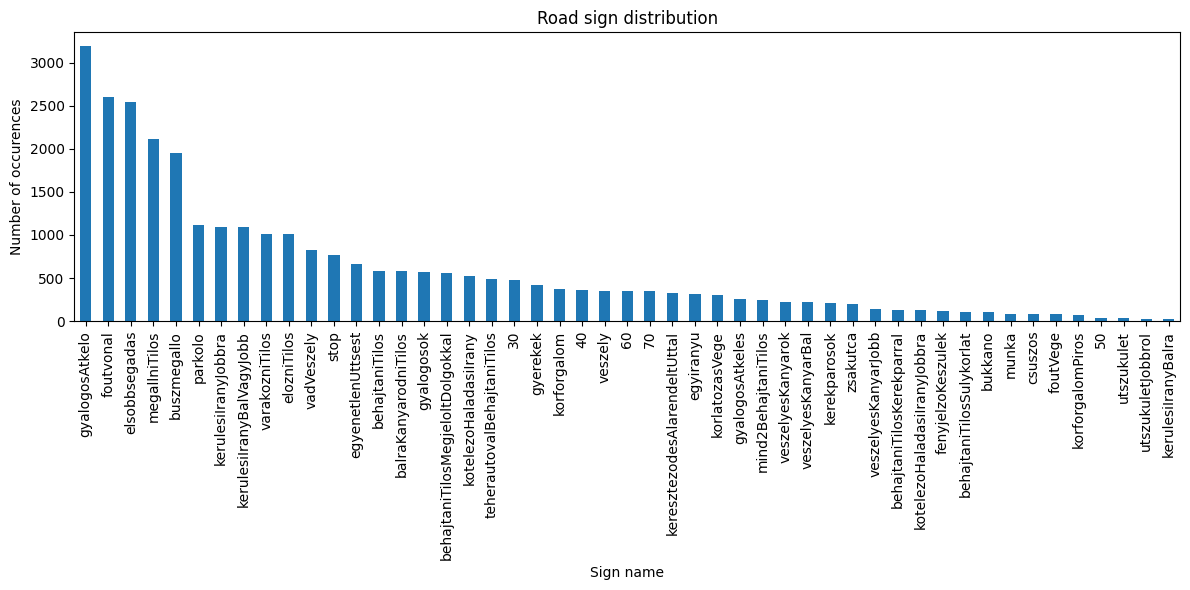

In [16]:
df = pd.read_csv(labels_csv_path)

label_counts = df.drop(columns=["filename", "nincs"]).sum().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title("Road sign distribution")
plt.xlabel("Sign name")
plt.ylabel("Number of occurences")
plt.tight_layout()
plt.show()


In [11]:
labels_df = pd.read_csv(labels_csv_path)

In [12]:
filtered_df = pd.read_csv(filtered_path)

## Training dataset construction

In [13]:
# Loading dataset
image_paths = [str(multi_label_dir) + "/" + fname for fname in filtered_df["filename"]]
labels = filtered_df.drop(columns=["filename"]).values.astype("float32")

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = image / 255.0
    return image, label

In [14]:
# tf.data.Dataset construction
tf_dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

tf_dataset = tf_dataset.map(
    load_image, num_parallel_calls=DATA_AUTOTUNE
)
tf_dataset = tf_dataset.shuffle(
    buffer_size=buffer_size, seed=SEED
)

In [15]:
# Splitting Train/Val
total_size = len(image_paths)
train_size = int(total_size * 0.8)

train_ds = tf_dataset.take(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)
val_ds = tf_dataset.skip(train_size).batch(batch_size).prefetch(DATA_AUTOTUNE)

# Sign names 
sign_names =filtered_df.columns.drop("filename").tolist()

print(f"Dataset loaded. Number if images: {total_size}")

Dataset loaded. Number if images: 22542


## Model construction

In [16]:
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, bias=True, dim=-1, **kwargs):
        """
        SwiGLU Activation Layer
        """
        super(SwiGLU, self).__init__(**kwargs)
        self.bias = bias
        self.dim = dim
        self.dense = tf.keras.layers.Dense(2, use_bias=bias)
        
        def call(self, x):
            out, gate = tf.split(x, num_split=2, axis=self.dim)
            gate = tf.keras.activations.swish(gate)
            x = tf.multiply(out, gate)
            return x

In [17]:
# Új kipróbálása

base_model = MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    alpha=1.4
)
base_model.trainable = True 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(
        512,
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    
    layers.Dense(
        256, 
        activation=activation_func,
        kernel_initializer=dense_initializer,
        #  kernel_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
        #  activity_regularizer=tf.keras.regularizers.L1L2(0.1, 0.1),
    ),
    
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(
        len(sign_names),
        #  kernel_initializer='glorot_uniform',
        activation='sigmoid'
    )
])

In [33]:
base_model.summary()

Model: "mobilenetv2_1.40_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 48  1296        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 48  192         ['Conv1[0][0]']                  
                                )                                              

## Training

In [ ]:
# TODO
# Class weights by TF (modified)

from sklearn.utils import class_weight

sk_class_weights = dict(enumerate(
    class_weight.compute_class_weight('balanced', 
                                      classes=class_names, 
                                      y=np.concatenate([train_labels, valid_labels])
                                      )
                                  )
                        )
sk_class_weights[1] /= 2
print("SK Weights:", sk_class_weights)

# Weight calculation

# Betöltés
df = pd.read_csv(filtered_path)

# Címkeoszlopok kiválasztása
label_cols = [col for col in df.columns if col != "filename"]

# Összes sor száma
n_samples = len(df)

# Súlyok kiszámítása
class_weights = {}

for i, col in enumerate(label_cols):
    positives = df[col].sum()
    negatives = n_samples - positives

    weight_for_1 = (1 / positives) * (n_samples / 2.0)
    weight_for_0 = (1 / negatives) * (n_samples / 2.0)

    for k in class_weights:
        class_weights[k] /= 5.0


# A class_weights mostantól átadható model.fit(...)-nek


NameError: name 'train_labels' is not defined

In [18]:
# Callbacks

callbacks = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     chekpoint_path,
    #     monitor="val_accuracy",
    #     verbose=1,
    #     save_best_only=True,
    #     save_weights_only=False,
    #     mode="max",
    #     save_freq="epoch",
    #     initial_value_threshold=0.92,
    # ), 
    # tf.keras.callbacks.TensorBoard(
    #     log_path,
    #     histogram_freq=0,
    #     write_steps_per_second=True,
    #     write_images=False,
    #     profile_batch='10, 15',
    # ), 
    tf.keras.callbacks.EarlyStopping(
        monitor='loss', 
        patience=3, 
        mode='min',
        restore_best_weights=True,
        verbose=1
    ),
    #tf.keras.callbacks.Progbar # Logger(),
    
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_recall',
        mode='max',
        factor=0.5,
        patience=2,
        min_lr=1e-6
        )
]# # # # # # # # # # # # # # 

In [19]:
# Compiling

#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=criterion,
    metrics=[
        "accuracy", # tf.keras.metrics.Accuracy(name='accuracy'),
        # tf.keras.metrics.AUC(name='AUC'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
    ]
)

In [ ]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    validation_freq=1,
    callbacks=callbacks, 
    # shuffle=True,
    # class_weight=sk_class_weights,
    use_multiprocessing=True
   #  verbose=2
)

Epoch 1/10


## Model performance visualization

1/1 [==============================] - 1s 683ms/step


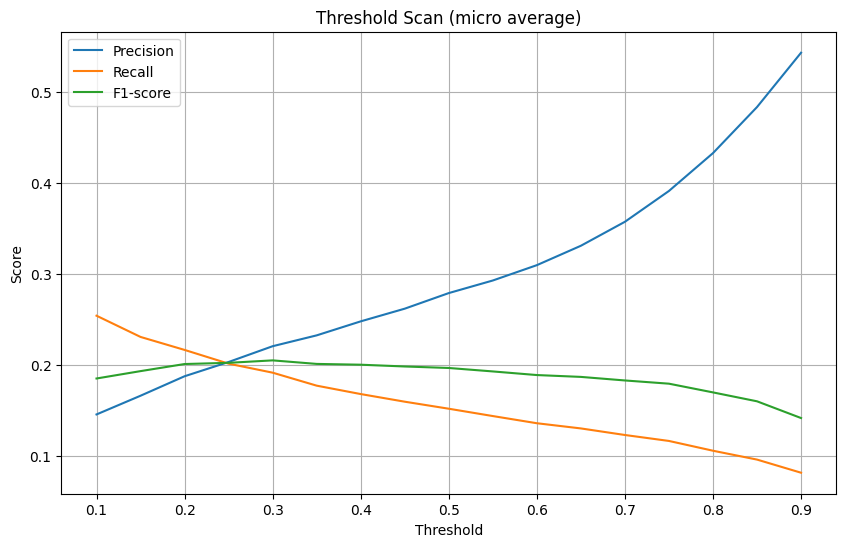

In [89]:
# Valódi címkék és predikciók összegyűjtése
all_preds = []
all_labels = []

for images, labels in val_ds.unbatch().batch(64):  # hogy gyorsabb legyen
    preds = model.predict(images)
    all_preds.append(preds)
    all_labels.append(labels.numpy())

# Összefűzés
y_true = np.vstack(all_labels)
y_pred = np.vstack(all_preds)

# Threshold-scan
thresholds = np.arange(0.1, 0.91, 0.05)
precisions = []
recalls = []
f1s = []

for t in thresholds:
    y_pred_bin = (y_pred > t).astype(int)
    precisions.append(precision_score(y_true, y_pred_bin, average='micro', zero_division=0))
    recalls.append(recall_score(y_true, y_pred_bin, average='micro', zero_division=0))
    f1s.append(f1_score(y_true, y_pred_bin, average='micro', zero_division=0))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1-score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Scan (micro average)")
plt.grid(True)
plt.legend()
plt.show()

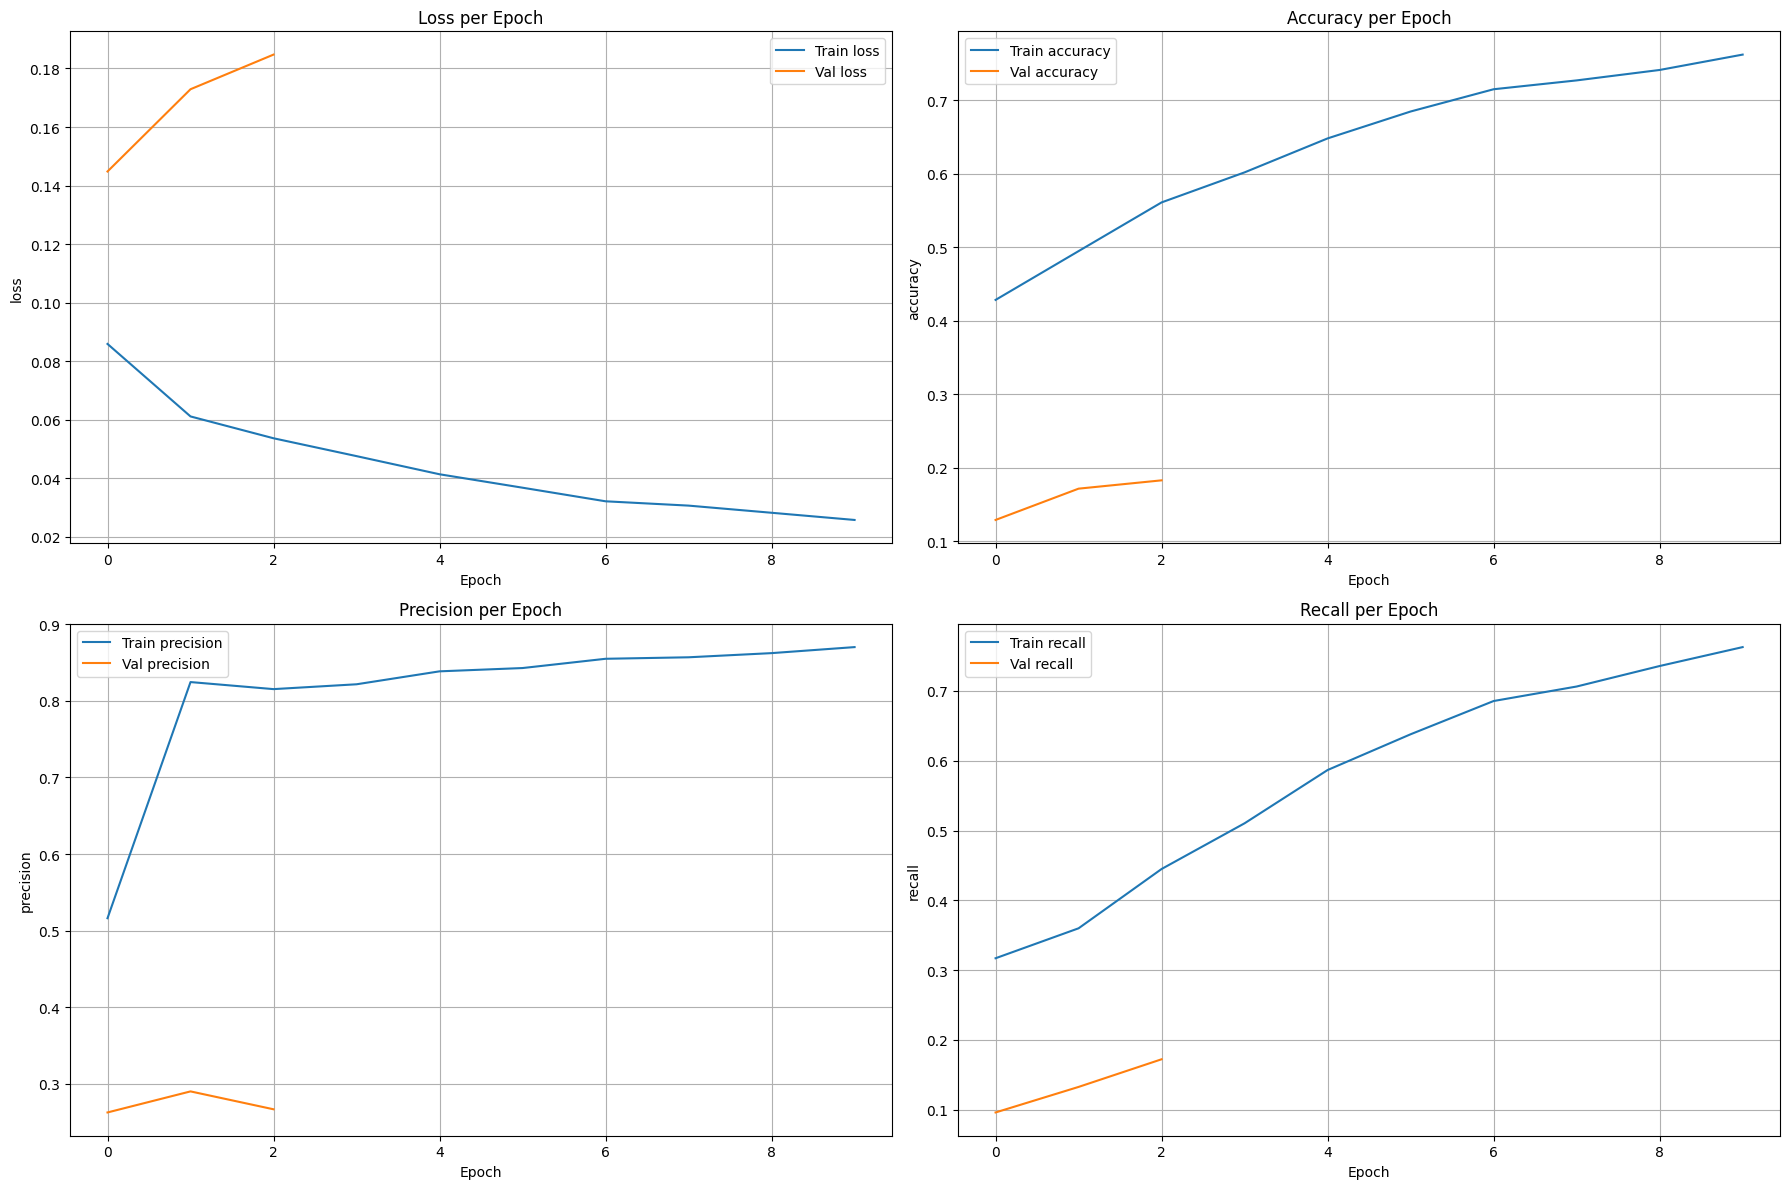

In [91]:
def plot_training_history(history):
    metrics = [
        'loss',
        'accuracy',
        'precision',
        'recall',
    ]

    plt.figure(figsize=(18, 12))
    rows = (len(metrics) + 1) // 2

    for i, metric in enumerate(metrics, 1):
        plt.subplot(rows, 2, i)
        plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_', ' ').capitalize()} per Epoch")
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()
    
plot_training_history(history)

In [60]:
model.save(f"../mentett_model/proba.keras")

In [27]:
# Save model as a keras file
model.save(f"../mentett_model/model_{exp_name}.keras")


# Save model as a .h5 file
#model.save(f"../mentett_model/traffic_sign_model_{exp_name}.h5")


# Save model as a tf file
#model.save(f"../mentett_model/multilabel_model_{exp_name}.tf", save_format="tf")

In [59]:
print(model_path)

../mentett_model/proba.keras


In [62]:
# Loading in the saved model
model = load_model(model_path)

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.30_224 (Funct  (None, 8, 8, 1664)       3766048   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1664)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 384)               639360    
                                                                 
 batch_normalization (BatchN  (None, 384)              1536      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 384)               0         
                                                        

In [92]:
# Prediction for 10 random images from MultiLabelFrames

THRESHOLD = 0.7
NUM_SAMPLES = 10

#model = load_model(model_path)
df = pd.read_csv(Path(multi_label_dir) / "labels.csv")
sign_names = df.columns.drop("filename").tolist()

# Select randomly
samples = df.sample(NUM_SAMPLES, random_state=42)

def load_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = tf.expand_dims(image / 255.0, axis=0)
    return image

# Predict and show
for _, row in samples.iterrows():
    image_path = str(Path(multi_label_dir) / row["filename"])
    label_vector = row.drop("filename").values.astype("float32")
    true_labels = [sign for sign, val in zip(sign_names, label_vector) if val == 1]

    image = load_image(image_path)
    prediction = model.predict(image)[0]
    predicted_labels = [sign for sign, val in zip(sign_names, prediction) if val > THRESHOLD]

    print(f"{row['filename']}")
    print(f"Real labels      : {true_labels}")
    print(f"Model prediction : {predicted_labels}")
    print("-" * 60)


1/1 [==============================] - 0s 260ms/step
0157_24.0_720_nincs.jpg
Real labels      : ['nincs']
Model prediction : []
------------------------------------------------------------
1/1 [==============================] - 0s 28ms/step
0296_59.0_1771.jpg
Real labels      : ['varakozniTilos']
Model prediction : []
------------------------------------------------------------
1/1 [==============================] - 0s 21ms/step
0287_67.5_4051.jpg
Real labels      : ['vadVeszely']
Model prediction : ['vadVeszely']
------------------------------------------------------------
1/1 [==============================] - 0s 22ms/step
0294_144.0_4320.jpg
Real labels      : ['gyalogosAtkelo']
Model prediction : []
------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
0294_74.0_2221.jpg
Real labels      : ['kotelezoHaladasiIrany']
Model prediction : []
------------------------------------------------------------
1/1 [======================

1/1 [==============================] - 0s 25ms/step
                                  precision    recall  f1-score   support

                              30       0.91      0.89      0.90       447
                              50       1.00      0.19      0.33        36
                              60       0.83      0.62      0.71       336
                              70       0.87      0.60      0.71       373
                     elozniTilos       0.93      0.52      0.66       969
    keresztezodesAlarendeltUttal       0.96      0.65      0.77       327
                       foutvonal       0.71      0.90      0.80      2522
                   elsobbsegadas       0.68      0.82      0.74      2412
                            stop       0.97      0.88      0.92       675
             mind2BehajtaniTilos       0.89      0.54      0.67       192
      teherautovalBehajtaniTilos       0.98      0.43      0.60       447
                  behajtaniTilos       0.91      0.60      

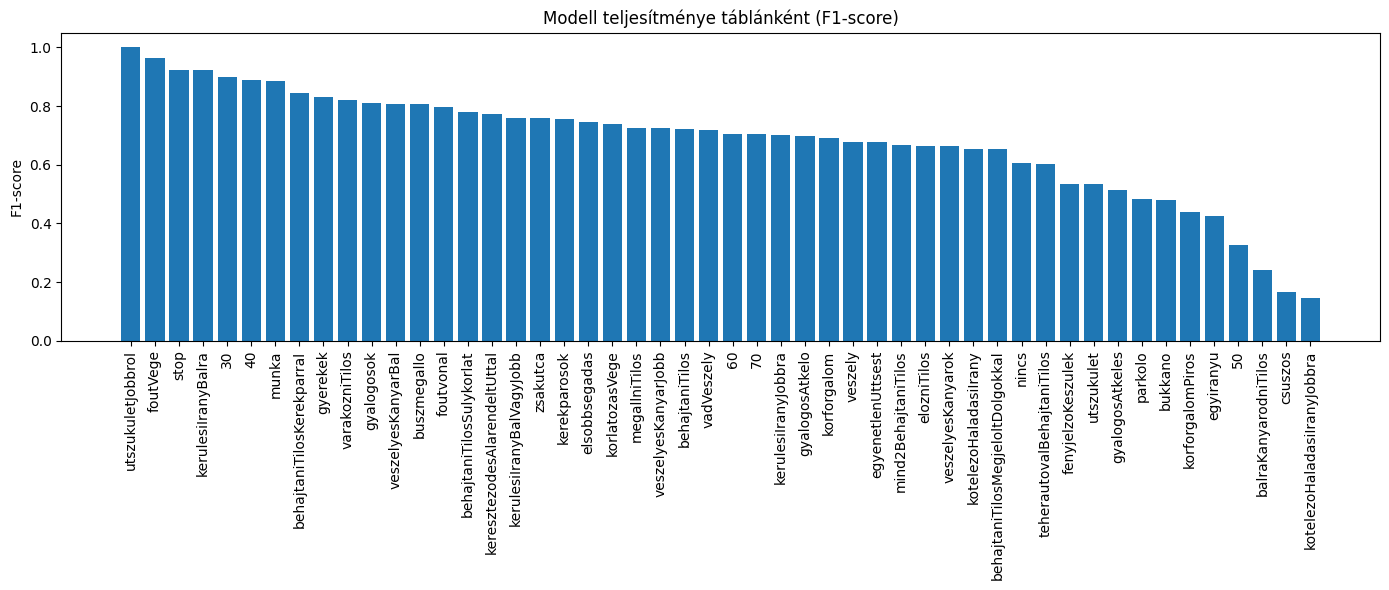

In [67]:
# F1-score for all road signs

THRESHOLD = 0.4

df = pd.read_csv(filtered_path)
sign_names = df.columns.drop("filename").tolist()
label_map = {name: i for i, name in enumerate(sign_names)}

def gen():
    for _, row in df.iterrows():
        path = str(Path(multi_label_dir) / row["filename"])
        label = row.drop("filename").values.astype("float32")
        yield path, label

def preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (img_size, img_size))
    image = image / 255.0
    return image, label

ds = tf.data.Dataset.from_generator(
    gen,
    output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(len(sign_names),), dtype=tf.float32)
    )
).map(preprocess).batch(batch_size)

#model = load_model(model_path)

y_true = []
y_pred = []

for images, labels in ds:
    probs = model.predict(images)
    preds = (probs > THRESHOLD).astype(int)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

print(classification_report(np.array(y_true), np.array(y_pred), target_names=sign_names, zero_division=0))

report_dict = classification_report(
    np.array(y_true), np.array(y_pred),
    target_names=sign_names,
    zero_division=0,
    output_dict=True
)

f1_scores = {label: metrics["f1-score"] for label, metrics in report_dict.items() if label in sign_names}

f1_sorted = dict(sorted(f1_scores.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(14, 6))
plt.bar(f1_sorted.keys(), f1_sorted.values())
plt.xticks(rotation=90)
plt.ylabel("F1-score")
plt.title("Modell teljesítménye táblánként (F1-score)")
plt.tight_layout()
plt.show()


In [71]:
# Prediction for videos to CSV files

VIDEO_PATH = Path(video_dir)/"0298.mp4"
OUTPUT_CSV = Path(detections_path)/"0298.csv"
THRESHOLD = 0.7
TIMESTEP = 0.5


model = load_model(model_path)

label_path = Path("../MultiLabelFrames/labels.csv")
df_labels = pd.read_csv(label_path)
sign_names = df_labels.columns.drop("filename").tolist()

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
duration = frame_count / fps

timestamps = np.arange(0, duration, TIMESTEP)
results = []

for t in timestamps:
    cap.set(cv2.CAP_PROP_POS_MSEC, t * 1000)
    ret, frame = cap.read()
    if not ret:
        results.append([t] + [0] * len(sign_names))
        continue

    frame = cv2.resize(frame, (img_size, img_size))
    image = tf.convert_to_tensor(frame / 255.0, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    preds = model.predict(image)[0]
    labels = (preds > THRESHOLD).astype(int).tolist()

    results.append([t] + labels)

cap.release()

df_out = pd.DataFrame(results, columns=["timestamp"] + sign_names)
Path(OUTPUT_CSV).parent.mkdir(parents=True, exist_ok=True)
df_out.to_csv(OUTPUT_CSV, index=False)
print("Done:", OUTPUT_CSV)


1/1 [==============================] - 0s 25ms/step
Done: ..\Detections\0298.csv


In [77]:
# Visual representation for the predictions

VIDEO_PATH = Path(video_dir)/"0298.mp4"
CSV_PATH = Path(detections_path)/"0298.csv"
#IMG_SIZE = (960, 540)
IMG_SIZE = (1440, 900)

df = pd.read_csv(CSV_PATH)
columns = df.columns.tolist()
timestamp_col = columns[0]
label_cols = columns[1:]

cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)

# User Interface
class PredictionViewer:
    def __init__(self, root):
        self.root = root
        self.root.title("Model prediction")

        self.canvas = tk.Canvas(root, width=IMG_SIZE[0], height=IMG_SIZE[1])
        self.canvas.grid(row=0, column=0, columnspan=3)

        self.info_label = tk.Label(root, text="", font=("Arial", 12), justify="left")
        self.info_label.grid(row=1, column=0, columnspan=3, pady=10)

        self.back_btn = tk.Button(root, text="<< Back", command=self.prev_frame)
        self.back_btn.grid(row=2, column=0)

        self.forward_btn = tk.Button(root, text="Next >>", command=self.next_frame)
        self.forward_btn.grid(row=2, column=2)

        self.frame_index = 0
        self.update_frame()

    def update_frame(self):
        row = df.iloc[self.frame_index]
        timestamp = row[timestamp_col]
        cap.set(cv2.CAP_PROP_POS_MSEC, timestamp * 1000)
        ret, frame = cap.read()
        if not ret:
            return
        frame = cv2.resize(frame, IMG_SIZE)
        img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        imgtk = ImageTk.PhotoImage(image=img)
        self.canvas.imgtk = imgtk
        self.canvas.create_image(0, 0, anchor='nw', image=imgtk)

        detected = [name for name in label_cols if row[name] == 1]
        text = f"Idő: {timestamp:.1f} s\nFelismert táblák: {', '.join(detected) if detected else 'nincs'}"
        self.info_label.config(text=text)

    def next_frame(self):
        if self.frame_index + 1 < len(df):
            self.frame_index += 1
            self.update_frame()

    def prev_frame(self):
        if self.frame_index > 0:
            self.frame_index -= 1
            self.update_frame()

In [78]:
# Launch user interface
if __name__ == "__main__":
    root = tk.Tk()
    app = PredictionViewer(root)
    root.mainloop()

In [ ]:
# Delete model from memory

from tensorflow.keras import backend as K
import gc

del model
K.clear_session()
gc.collect()

print("model is succesfully deleted from the memory")


model is succesfully deleted from the memory
